In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
import warnings
import yfinance as yf
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

def LB(ts, lags=[12], g=0):
    result = sm.stats.diagnostic.acorr_ljungbox(ts, lags=lags, model_df=g, return_df=True)
    return result.iloc[-1]['lb_pvalue']

def LBdf(ts, lags=[12], g=0, caption=''):
    print('*************************')
    print(f'Ljung-Box Test on {caption}')
    result = sm.stats.diagnostic.acorr_ljungbox(ts, lags=lags, model_df=g, return_df=True)
    return result

def ACF(ts, lags=24, title='ACF'):
    sm.graphics.tsa.plot_acf(ts, auto_ylims=True, lags=lags, title=title)
    
def PACF(ts, lags=24, title='PACF'):
    sm.graphics.tsa.plot_pacf(ts, auto_ylims=True, lags=lags, title=title)

def ADFT(ts, alpha=0.05, l=12, caption='The time series'):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(ts, maxlag=l)
    print('*************************')
    print('ADF Test on stationarity')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= alpha:
        print(f'{caption} is stationary.')
    else:
        print(f'{caption} is not stationary.')
    return 

def arma_grid_aic(X, mp=5, d=0, mq=5, caption='rt'):
    target = []
    for k in range(d+1):
        for i in range(mp):
            for j in range(mq):
                print(f'Calculating...p={i},d={k},q={j}')
                model = ARIMA(X, order=(i,k,j))
                model_fit = model.fit()
                QM = LB(model_fit.resid, g=i+j)
                if QM > 0.05:
                    target.append([(i,k,j), model_fit.aic, model_fit.bic])
    tdf = pd.DataFrame(target, columns=['order','aic','bic']).sort_values(by='aic')
    try:
        print(f'{tdf.order.iloc[0]} is the best combination for {caption}')
        return tdf, tdf.order.iloc[0]
    except:
        print('Cannot find appropriate model')
        return tdf, 'N/A'


In [2]:
# Data preparation
df = yf.Ticker('0005.hk').history(period='max')
df = df[df.Volume!=0].dropna()
df['R_High'] = df['High'].pct_change()
df['R_Low'] = df['Low'].pct_change()
df['R_Close'] = df['Close'].pct_change()
df['r_High'] = np.log(df['R_High']+1)
df['r_Low'] = np.log(df['R_Low']+1)
df['r_Close'] = np.log(df['R_Close']+1)
n = len(df)
c = df.index.get_loc('2016').start

*************************
ADF Test on stationarity
ADF Statistic: -23.939028348593475
p-value: 0.0
The time series is stationary.
*************************
Ljung-Box Test on r_High
      lb_stat     lb_pvalue
12  64.619108  3.205883e-09
                               SARIMAX Results                                
Dep. Variable:                 r_High   No. Observations:                 3938
Model:                 ARIMA(6, 0, 0)   Log Likelihood               11078.641
Date:                Thu, 25 Nov 2021   AIC                         -22141.282
Time:                        15:45:19   BIC                         -22091.055
Sample:                             0   HQIC                        -22123.464
                               - 3938                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

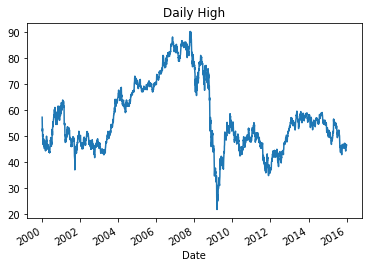

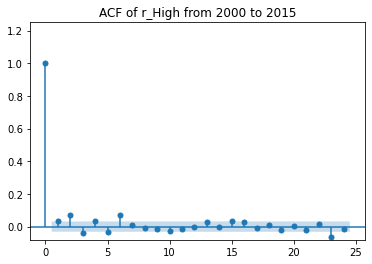

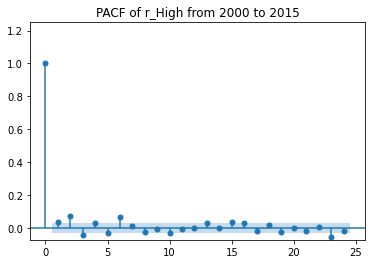

In [3]:
# Model checking - High
df['High'][:c].plot(title='Daily High')
train_high, test_high = df['r_High'][1:c], df['r_High'][c:]
ADFT(train_high)
print(LBdf(train_high, caption='r_High'))
ACF(train_high, title='ACF of r_High from 2000 to 2015')
PACF(train_high, title='PACF of r_High from 2000 to 2015')

order_high = (6,0,0)
mh = ARIMA(train_high, order=order_high).fit()
print(mh.summary())
print(LBdf(mh.resid, [10], g=sum(order_high), caption='residual of AR model'))
print(LBdf(mh.resid**2, [10], g=sum(order_high), caption='squared residual of AR model'))
at_h = mh.resid
mh_garch = arch_model(at_h, mean='Zero', vol='GARCH', p=1, q=1, dist='Normal').fit()
print(mh_garch.summary())
print(LBdf(mh_garch.std_resid, [20], caption='residual of GARCH model'))
print(LBdf(mh_garch.std_resid**2, [20], caption='squared residual of GARCH model'))

*************************
ADF Test on stationarity
ADF Statistic: -17.482318357719034
p-value: 4.4824168341766024e-30
The time series is stationary.
*************************
Ljung-Box Test on r_Low
      lb_stat  lb_pvalue
12  46.086404   0.000007
                               SARIMAX Results                                
Dep. Variable:                  r_Low   No. Observations:                 3938
Model:                 ARIMA(2, 0, 0)   Log Likelihood               10744.716
Date:                Thu, 25 Nov 2021   AIC                         -21481.432
Time:                        15:45:23   BIC                         -21456.318
Sample:                             0   HQIC                        -21472.523
                               - 3938                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

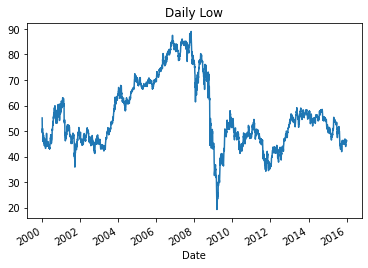

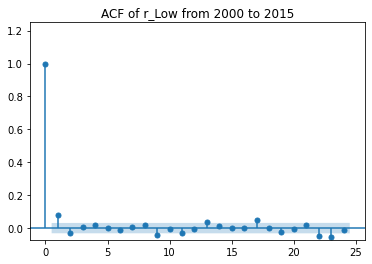

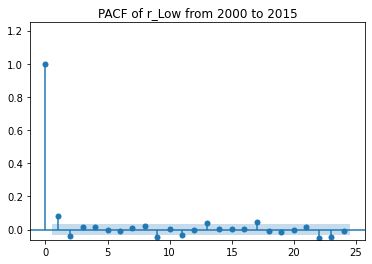

In [4]:
# Model checking - Low
df['Low'][:c].plot(title='Daily Low')
train_low, test_low = df['r_Low'][1:c], df['r_Low'][c:]
ADFT(train_low)
print(LBdf(train_low, caption='r_Low'))
ACF(train_low, title='ACF of r_Low from 2000 to 2015')
PACF(train_low, title='PACF of r_Low from 2000 to 2015')

order_low = (2,0,0)
ml = ARIMA(train_low, order=order_low).fit()
print(ml.summary())
print(LBdf(ml.resid, [10], g=sum(order_low), caption='residual of AR model'))
print(LBdf(ml.resid**2, [10], g=sum(order_low), caption='squared residual of AR model'))
at_l = ml.resid
ml_garch = arch_model(at_l, mean='Zero', vol='GARCH', p=1, q=1, dist='Normal').fit()
print(ml_garch.summary())
print(LBdf(ml_garch.std_resid, [20], caption='residual of GARCH model'))
print(LBdf(ml_garch.std_resid**2, [20], caption='squared residual of GARCH model'))

*************************
ADF Test on stationarity
ADF Statistic: -17.199896290609757
p-value: 6.469929490333993e-30
The time series is stationary.
*************************
Ljung-Box Test on r_Close
      lb_stat  lb_pvalue
12  24.267148   0.018704
                                   SARIMAX Results                                    
Dep. Variable:                        r_Close   No. Observations:                 3938
Model:             ARIMA([1, 4, 9, 11], 0, 0)   Log Likelihood               10554.576
Date:                        Thu, 25 Nov 2021   AIC                         -21097.151
Time:                                15:45:29   BIC                         -21059.481
Sample:                                     0   HQIC                        -21083.787
                                       - 3938                                         
Covariance Type:                          opg                                         
                 coef    std err          z      P>|z|

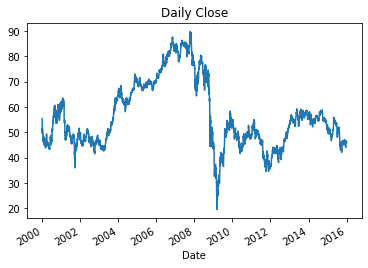

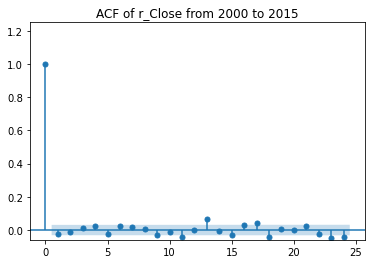

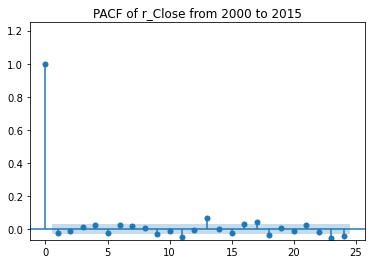

In [5]:
# Model checking - Close
df['Close'][:c].plot(title='Daily Close')
train_close, test_close = df['r_Close'][1:c], df['r_Close'][c:]
ADFT(train_close)
print(LBdf(train_close, caption='r_Close'))
ACF(train_close, title='ACF of r_Close from 2000 to 2015')
PACF(train_close, title='PACF of r_Close from 2000 to 2015')

order_close = ([1,4,9,11],0,0)
mc = ARIMA(train_close, order=order_close).fit()
print(mc.summary())
print(LBdf(mc.resid, [10], g=4, caption='residual of AR model'))
print(LBdf(mc.resid**2, [10], g=4, caption='squared residual of AR model'))
at_c = mc.resid
mc_garch = arch_model(at_c, mean='Zero', vol='GARCH', p=1, q=1, dist='Normal').fit()
print(mc_garch.summary())
print(LBdf(mc_garch.std_resid, [20], caption='residual of GARCH model'))
print(LBdf(mc_garch.std_resid**2, [20], caption='squared residual of GARCH model'))

The following code used to make prediction on test data and will take sevearal hours to run.
Please skip and read the result instead.

In [ ]:
rh = []
rh_se = []
rl = []
rl_se = []
rc = []
rc_se = []
c1 = c
while c1 < n:
    # predicting High
    print(f'Forecasting {df.index[c1]}')
    dh = df['r_High'][1:c1]
    model_high = ARIMA(dh, order=order_high).fit()
    rh.append(model_high.get_forecast(1).predicted_mean.iloc[0])
    model_high_garch = arch_model(model_high.resid, mean='Zero', vol='GARCH', p=1, q=1, dist='Normal').fit(update_freq=0, disp='off')
    rh_se.append(np.sqrt(model_high_garch.forecast().variance['h.1'].iloc[-1]))

    # predicting Low
    dl = df['r_Low'][1:c1]
    model_low = ARIMA(dl, order=order_low).fit()
    rl.append(model_low.get_forecast(1).predicted_mean.iloc[0])
    model_low_garch = arch_model(model_low.resid, mean='Zero', vol='GARCH', p=1, q=1, dist='Normal').fit(update_freq=0, disp='off')
    rl_se.append(np.sqrt(model_low_garch.forecast().variance['h.1'].iloc[-1]))

    # predicting Close
    dc = df['r_Close'][1:c1]
    model_close = ARIMA(dc, order=order_close).fit()
    rc.append(model_close.get_forecast(1).predicted_mean.iloc[0])
    model_close_garch = arch_model(model_close.resid, mean='Zero', vol='GARCH', p=1, q=1, dist='Normal').fit(update_freq=0, disp='off')
    rc_se.append(np.sqrt(model_close_garch.forecast().variance['h.1'].iloc[-1]))

    c1 += 1

df_sim = df[df.index.get_loc('2016').start:]
df_sim['rhat_High'] = rh
df_sim['rhat_High_se'] = rh_se
df_sim['rhat_Low'] = rl
df_sim['rhat_Low_se'] = rl_se
df_sim['rhat_Close'] = rc
df_sim['rhat_Close_se'] = rc_se
df_sim = pd.concat([df_sim, df.loc['2015-12-31'].to_frame().T]).sort_index()
df_sim['Phat_High'] = df_sim['High'].shift(1)*np.exp(df_sim['rhat_High'])
df_sim['Phat_Low'] = df_sim['Low'].shift(1)*np.exp(df_sim['rhat_Low'])
df_sim['Phat_Close'] = df_sim['Close'].shift(1)*np.exp(df_sim['rhat_Close'])
df_sim['Phat_High_upper'] = df_sim['High'].shift(1)*np.exp(df_sim['rhat_High']+1.96*df_sim['rhat_High_se'])
df_sim['Phat_High_lower'] = df_sim['High'].shift(1)*np.exp(df_sim['rhat_High']-1.96*df_sim['rhat_High_se'])
df_sim['Phat_Low_upper'] = df_sim['Low'].shift(1)*np.exp(df_sim['rhat_Low']+1.96*df_sim['rhat_Low_se'])
df_sim['Phat_Low_lower'] = df_sim['Low'].shift(1)*np.exp(df_sim['rhat_Low']-1.96*df_sim['rhat_Low_se'])
df_sim['Phat_Close_upper'] = df_sim['Close'].shift(1)*np.exp(df_sim['rhat_Close']+1.96*df_sim['rhat_Close_se'])
df_sim['Phat_Close_lower'] = df_sim['Close'].shift(1)*np.exp(df_sim['rhat_Close']-1.96*df_sim['rhat_Close_se'])


Read the result of prediction as of 24 November 2021 with below code.

path is where the file 'HSBC_20211124_Predict2016+.csv' is located.

In [6]:
path = '.\\Output\\HSBC_20211124_Predict2016+.csv'
df_sim = pd.read_csv(path, index_col=0)

In [7]:
d = df_sim[1:]
P_High_percent = sum((d.High<=d.Phat_High_upper) & (d.High>=d.Phat_High_lower))/len(d)*100
P_Low_percent = sum((d.Low<=d.Phat_Low_upper) & (d.Low>=d.Phat_Low_lower))/len(d)*100
P_Close_percent = sum((d.Close<=d.Phat_Close_upper) & (d.Close>=d.Phat_Close_lower))/len(d)*100
print(f'% of P_High within prediction interval: {P_High_percent:.2f}%')
print(f'% of P_Low within prediction interval: {P_Low_percent:.2f}%')
print(f'% of P_Close within prediction interval: {P_Close_percent:.2f}%')

% of P_High within prediction interval: 93.37%
% of P_Low within prediction interval: 94.41%
% of P_Close within prediction interval: 93.72%


Number of Long Order placed: 709
Number of Long Order executed : 544
Long Order executed rate: 76.73%
Number of Short Order placed: 739
Number of Short Order executed : 563
Short Order executed rate: 76.18%
Account Balance: 3.83


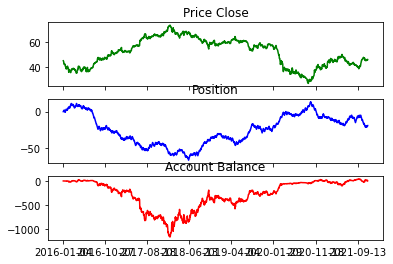

In [8]:
# Strategy A (6.1)
sa = df_sim[['High','Low','Close','r_Close','rhat_Close']][1:]
sa['Order'] = ((sa['rhat_Close']>0).astype(int)-(sa['rhat_Close']<0).astype(int)).shift(1)
sa['Order_Price']=sa['Close'].shift(1)
sa['Order_Success']=0
bdf = sa[sa.Order==1]
sa.loc[sa.Order==1, 'Order_Success'] = (bdf['Order_Price']>=bdf['Low']).astype(int)
sdf = sa[sa.Order==-1]
sa.loc[sa.Order==-1, 'Order_Success'] = (sdf['Order_Price']<=sdf['High']).astype(int)
sa['Trade_Price']=0
sa.loc[(sa.Order_Success==1) & (sa.Order==1), 'Trade_Price'] = sa.loc[(sa.Order_Success==1) & (sa.Order==1), ['High','Order_Price']].min(axis=1)
sa.loc[(sa.Order_Success==1) & (sa.Order==-1), 'Trade_Price'] = sa.loc[(sa.Order_Success==1) & (sa.Order==-1), ['Low','Order_Price']].max(axis=1)
sa['Transaction'] = (-sa.Order*sa.Trade_Price).fillna(0)
sa['Cash'] = sa.Transaction.cumsum().fillna(0)
sa['Position'] = (sa.Order*sa.Order_Success).cumsum().fillna(0)
sa['Balance'] = sa.Cash+sa.Position*sa.Close

fig, ax = plt.subplots(3, sharex=True)
sa.Close.plot(ax=ax[0], style='g-', title='Price Close')
sa.Position.plot(ax=ax[1], style='b-', title='Position')
sa.Balance.plot(ax=ax[2], style='r-', title='Account Balance')

print(f'Number of Long Order placed: {len(sa.loc[sa.Order==1])}')
print(f'Number of Long Order executed : {sum(sa.loc[sa.Order_Success==1, "Order"]==1)}')
print(f'Long Order executed rate: {sum(sa.loc[sa.Order_Success==1, "Order"]==1)/len(sa.loc[sa.Order==1])*100:.2f}%')
print(f'Number of Short Order placed: {len(sa.loc[sa.Order==-1])}')
print(f'Number of Short Order executed : {sum(sa.loc[sa.Order_Success==1, "Order"]==-1)}')
print(f'Short Order executed rate: {sum(sa.loc[sa.Order_Success==1, "Order"]==-1)/len(sa.loc[sa.Order==-1])*100:.2f}%')
print(f'Account Balance: {sa.Balance.iloc[-1]:.2f}')

Number of Long and Short Order placed: 1449
Number of Long Order executed : 687
Long Order executed rate: 47.41%
Number of Short Order executed : 704
Short Order executed rate: 48.59%
Account Balance: 313.80


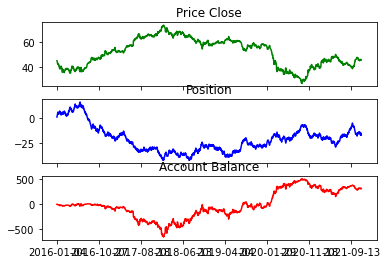

In [9]:
# Strategy B (6.2)
sb = df_sim[['High','Phat_High','Low','Phat_Low','Close']][1:]
sb['Order_Price_Short'] = sb['Phat_High']
sb['Order_Price_Long'] = sb['Phat_Low']
sb['Order_Success_Short'] = (sb.Order_Price_Short<=sb.High).astype(int)
sb['Order_Success_Long'] = (sb.Order_Price_Long>=sb.Low).astype(int)
sb['Trade_Price_Short'], sb['Trade_Price_Long'] = 0, 0
sb.loc[sb.Order_Success_Short==1,'Trade_Price_Short'] = sb.loc[sb.Order_Success_Short==1, ['Low','Order_Price_Short']].max(axis=1)
sb.loc[sb.Order_Success_Long==1,'Trade_Price_Long'] = sb.loc[sb.Order_Success_Long==1, ['High','Order_Price_Long']].min(axis=1)

sb['Transaction'] = sb.Order_Success_Short*sb.Trade_Price_Short-sb.Order_Success_Long*sb.Trade_Price_Long
sb['Cash'] = sb.Transaction.cumsum().fillna(0)
sb['Position'] = (sb.Order_Success_Long-sb.Order_Success_Short).cumsum().fillna(0)
sb['Balance'] = sb.Cash+sb.Position*sb.Close

fig, ax = plt.subplots(3, sharex=True)
sb.Close.plot(ax=ax[0], style='g-', title='Price Close')
sb.Position.plot(ax=ax[1], style='b-', title='Position')
sb.Balance.plot(ax=ax[2], style='r-', title='Account Balance')

print(f'Number of Long and Short Order placed: {len(sb)}')
print(f'Number of Long Order executed : {sum(sb.Order_Success_Long==1)}')
print(f'Long Order executed rate: {sum(sb.Order_Success_Long==1)/len(sb)*100:.2f}%')
print(f'Number of Short Order executed : {sum(sb.Order_Success_Short==1)}')
print(f'Short Order executed rate: {sum(sb.Order_Success_Short==1)/len(sb)*100:.2f}%')
print(f'Account Balance: {sb.Balance.iloc[-1]:.2f}')


Number of Long and Short Order placed: 4
Number of Long Order executed : 3
Long Order executed rate: 75.00%
Number of Short Order executed : 1
Short Order executed rate: 25.00%
Account Balance: -32.38


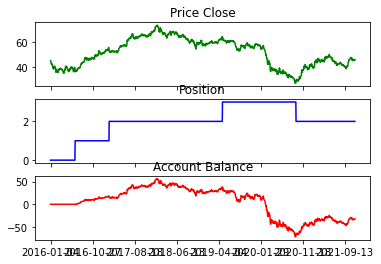

In [10]:
# Strategy C (6.3)
sc = df_sim[['High','Phat_High_upper', 'Phat_High_lower','Low','Phat_Low_upper','Phat_Low_lower','Close']][1:]
sc['Order_Placed'] = sc.Phat_Low_upper < sc.Phat_High_lower
sc['Order_Price_Short'] = sc['Phat_High_lower']
sc['Order_Price_Long'] = sc['Phat_Low_upper']
sc['Order_Success_Short'] = ((sc.Order_Placed==True) & (sc.Order_Price_Short<=sc.High)).astype(int)
sc['Order_Success_Long'] = ((sc.Order_Placed==True) & (sc.Order_Price_Long>=sc.Low)).astype(int)
sc['Trade_Price_Short'], sc['Trade_Price_Long'] = 0, 0
sc.loc[sc.Order_Success_Short==1,'Trade_Price_Short'] = sc.loc[sc.Order_Success_Short==1, ['Low','Order_Price_Short']].max(axis=1)
sc.loc[sc.Order_Success_Long==1,'Trade_Price_Long'] = sc.loc[sc.Order_Success_Long==1, ['High','Order_Price_Long']].min(axis=1)

sc['Transaction'] = sc.Order_Success_Short*sc.Trade_Price_Short-sc.Order_Success_Long*sc.Trade_Price_Long
sc['Cash'] = sc.Transaction.cumsum().fillna(0)
sc['Position'] = (sc.Order_Success_Long-sc.Order_Success_Short).cumsum().fillna(0)
sc['Balance'] = sc.Cash+sc.Position*sc.Close

fig, ax = plt.subplots(3, sharex=True)
sc.Close.plot(ax=ax[0], style='g-', title='Price Close')
sc.Position.plot(ax=ax[1], style='b-', title='Position')
sc.Balance.plot(ax=ax[2], style='r-', title='Account Balance')

print(f'Number of Long and Short Order placed: {sum(sc.Order_Placed)}')
print(f'Number of Long Order executed : {sum(sc.Order_Success_Long==1)}')
print(f'Long Order executed rate: {sum(sc.Order_Success_Long==1)/sum(sc.Order_Placed)*100:.2f}%')
print(f'Number of Short Order executed : {sum(sc.Order_Success_Short==1)}')
print(f'Short Order executed rate: {sum(sc.Order_Success_Short==1)/sum(sc.Order_Placed)*100:.2f}%')
print(f'Account Balance: {sc.Balance.iloc[-1]:.2f}')

Number of Long and Short Order placed: 1449
Number of Long Order executed : 48
Long Order executed rate: 3.31%
Number of Short Order executed : 48
Short Order executed rate: 3.31%
Account Balance: 36.05


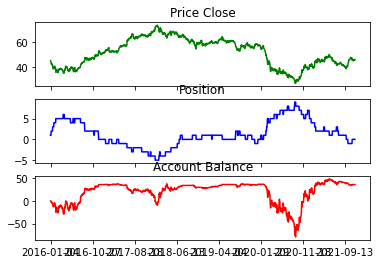

In [11]:
# Strategy D (6.4)
sd = df_sim[['High','Phat_High_upper', 'Phat_High_lower','Low','Phat_Low_upper','Phat_Low_lower','Close']][1:]
sd['Order_Price_Short'] = sd['Phat_High_upper']
sd['Order_Price_Long'] = sd['Phat_Low_lower']
sd['Order_Success_Short'] = (sd.Order_Price_Short<=sd.High).astype(int)
sd['Order_Success_Long'] = (sd.Order_Price_Long>=sd.Low).astype(int)
sd['Trade_Price_Short'], sd['Trade_Price_Long'] = 0, 0
sd.loc[sd.Order_Success_Short==1,'Trade_Price_Short'] = sd.loc[sd.Order_Success_Short==1, ['Low','Order_Price_Short']].max(axis=1)
sd.loc[sd.Order_Success_Long==1,'Trade_Price_Long'] = sd.loc[sd.Order_Success_Long==1, ['High','Order_Price_Long']].min(axis=1)

sd['Transaction'] = sd.Order_Success_Short*sd.Trade_Price_Short-sd.Order_Success_Long*sd.Trade_Price_Long
sd['Cash'] = sd.Transaction.cumsum().fillna(0)
sd['Position'] = (sd.Order_Success_Long-sd.Order_Success_Short).cumsum().fillna(0)
sd['Balance'] = sd.Cash+sd.Position*sd.Close

fig, ax = plt.subplots(3, sharex=True)
sd.Close.plot(ax=ax[0], style='g-', title='Price Close')
sd.Position.plot(ax=ax[1], style='b-', title='Position')
sd.Balance.plot(ax=ax[2], style='r-', title='Account Balance')

print(f'Number of Long and Short Order placed: {len(sd)}')
print(f'Number of Long Order executed : {sum(sd.Order_Success_Long==1)}')
print(f'Long Order executed rate: {sum(sd.Order_Success_Long==1)/len(sd)*100:.2f}%')
print(f'Number of Short Order executed : {sum(sd.Order_Success_Short==1)}')
print(f'Short Order executed rate: {sum(sd.Order_Success_Short==1)/len(sd)*100:.2f}%')
print(f'Account Balance: {sd.Balance.iloc[-1]:.2f}')